# Introduction 

##### Authors  :  Salim Boussofara (MT), Sarah Marciniak (GM), Frederic Pili (MT) and Victor Van den Heuvel (MT)

The following report aims at presenting the Project in Basics of Mobile Robotics. The goal of this project is to make a robot, Thymio, go along a planned path toward a goal while avoiding obstacles coming its way. The code is structured around five axis : vision, filtering, global navigation, local navigation and motion control. 

The report will explain each section of the code and the reasoning behind them. The last section contains the runable code explained in the section "Code explanation". Finally, the conclusion will explore the potential limits of our code and ways to improve it. The report will cover the following subjects : 

- Detection of objects on a map with contour detection.
- Color detection of goal and robot.
- Global path computation using Dijkstra's algorithm and visibility graphs.
- Path following and control algorithm.
- Kalman filter for navigation with and without vision. 
- Local obstacle avoidance using Neural Networks. 

The environnement in which the robot moves is as following : 

- The obstacles are three-dimensional and of various shapes.
- The goal is characterised by a blue dot.
- The robot is characterized as three green circles placed in a triangular shape on the top of the robot.
- Unknown obstacles have spherical shapes and are placed on the robot's path. 

 ### Table of Contents  
 
1. [Code Explanation](#code-explanation)
    1. [Vision](#vision)
    2. [Global Navigation and Path Planning](#global-navigation-and-path-planning)
        1. [Path Planning](#path)
        2. [Processing the polygons](#polygons) 
            1. [Reshape polygons](#reshape)
            2. [Process final contour](#countour)
            3. [Polygon to contour](#p2c)
        3. [Graph designing and path planning](#graph_design)
            1. [Create visibility graph](#visibility)
            2. [Shortest path](#shortest)
    3. [Filtering and motion control](#filtering)
        1. [Kalman filter](#kalman)
        2. [Motion control](#motion)
    4. [Local navigation](#local)
2. [Execution of the Code](#execution-of-the-code)
3. [Conclusion](#conclusion)
4. [References](#references)
5. [Appendices](#app)

# Code explanation  <a class="anchor" id="code-explanation"></a>

The code is structured around five axis : vision, filtering, global navigation, local navigation and motion control. The follwong section will explain how each axis has been implemented throughout the project. The following graph gives an intuitive overview of how each function interact with each other. 

![flowchart.png](videos/simple_scheme.png)

The following graph is a more detailed diagram showing what the differents modules share with each other in order to make the robot reach its target goal.


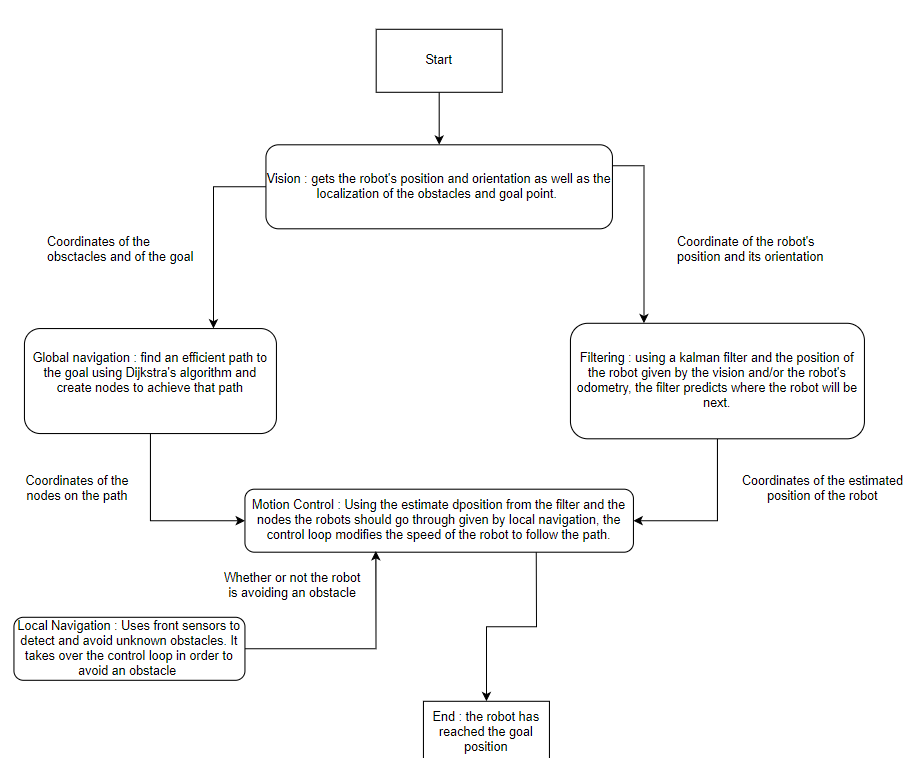

## Vision  <a class="anchor" id="vision"></a>

Vision is one of the central aspects of the application. It is the "eyes" of the robot, enabling it to measure successive robot positions, detect static obstacles, detect the point to be reached and the edges of the terrain. This section details the main components of this task, through the functions that make it up.

#### *Function* : `read_colored_circles(file, color)`
- *Inputs*: captured image (BGR colour space), colour of circles to be detected
- *Return*: list of detected coloured circle centres
- *Task*: 
This function uses colour detection in the HSV space, which allows the hue to be decoupled from the saturation and luminosity of the image, making detection much more robust to real lighting conditions. This function is asked to detect the green and blue colours, in order to obtain the position of the robot and the position of the goal respectively.

*Step 1:* The image received is converted from BGR space to HSV space.

*Step 2:* Two colour thresholds, high and low, are defined in order to create a mask. The thresholds are naturally different for each colour, but share the same saturation and lightness values: only the hue changes, so colours can be differentiated exclusively by their hue.

*Step 3:* A colour mask is created according to the colour, in order to select only the pixels whose colours are between the thresholds. A pixel-by-pixel comparison of the mask with the initial captured image is performed, and the H channel of the resulting image is extracted into a new image, `detection_array` [1].


*Step 4:* `detection_array` is prepared for circle detection: a Gaussian blur is applied to smooth out the intensity of the circles, and then the whole image is saturated with a binary threshold to bring out exactly what is coloured.
The use of Gaussian blur is particularly appropriate here, as the isotropy of the transformation allows the shape of the circles to be refined. This improves the quality of the binary saturation, especially as the regularity of the circles is a particularly important parameter for the circle detection which follows. 

*Step 5:* The previous image is ideal for detecting circles, using the `HoughCircles()` function [2]. A list is created storing the centres, which are added after rounding the coordinates.



#### *Function* : `get_goal(capture)`
- *Arguments*: captured image (BGR colour space)
- *Return*: position of the corresponding blue circle to reach
- *Task*: 
The function is called to obtain the position of the goal point. It calls up the detection of circles coloured with the blue colour (colour of the goal). It returns the position of this goal.

#### *Function* : `detection_ploygones(capture)`
- *Arguments*: captured image (BGR colour space)
- *Return* : a list containing N lists of vertex points of the N polygons detected
- *Task*:  The function identifies polygons in the image using Canny filter edge enhancement. Contours are detected and then approximated to polygons in order to extract the vertex points of the detected polygons. 

*Step 1:* The image received is converted from BGR space to grayscale.

*Step 2:* Before searching for contours, Gaussian blur is applied to reduce noise. Contours are highlighted by applying a Canny filter. A binary threshold is applied to bring out the exact contours.
The use of Gaussian blur is motivated by the three-dimensionality of the obstacles, which create shadows on the terrain. In our tests, we initially used median blur (to reduce noise while preserving edges), but we obtained better results with Gaussian blur, indicating that the shadows of the obstacles are a dominant factor.

The use of a Canny filter is motivated by its efficiency with regard to edges that stand out weakly, compared with a Sobel filter, for example. In our imperfect lighting conditions, because of the presence of shadows, the Canny filter appeared to be more robust. Despite its higher calculation cost, it was therefore preferred.

*Step 3:* The OpenCV `findContours()` function returns all the points making up the contours [3]. After plotting these contours on a new image, the contours are approximated as polygons to extract their vertices.

*Step 4:* For each polygon, a list of its vertices is added to the list of polygons, polygons.

#### *Function* : `get_field(polygons, size)`
- *Arguments*: list of detected polygons (list of vertex lists), size of captured image (linked to camera resolution)
- *Return*: list containing the four border points (corners)
- *Task*: 
The function identifies the position of the farthest polygons (by their centroids) on the terrain, which therefore correspond to the corners of the terrain.

*Step 1:* The position of the centroids of each polygon detected is calculated.

*Step 2:* For each corner in the image, the closest centroid is identified and added to the list of `field_corners`.

*Step 3:* The list of `field_corners` is returned.

#### *Function* : `get_robot_position(image)`
- *Arguments*: captured image (BGR colour space)
- *Return*: position of vertex of triangle (front of Thymio), position of Thymio (middle of base of triangle), angle of Thymio (orientation of triangle).
- *Task*: 
The Thymio is characterised by an isosceles triangle, with its vertex at the front of the robot. The robot's position is defined as the middle point of its base, and its orientation angle as the orientation of the triangle. The function calculates and returns the position of the midpoint of the base and the angle of orientation [4].

*Step 1:* Read the green coloured circles (using the `read_colored_circles` function) in order to identify the triangle on the ground.

*Step 2:* If detection is successful (3 points detected), the length of each side is calculated to find the base of the triangle (longest side).

*Step 3:* The midpoint is deduced, considered to be the robot's position. The angle of the central bisector of the triangle is calculated as the angle of the segment between the middle point of the base and the vertex.

In [ ]:
class Camera() :
    '''
    This class is used to implement the computer vision functions using the camera
    
    '''
    def __init__(self, camera=0, shape=[640, 480]) :
        self.camera = camera
        self.cap = 0
        self.height = shape[1]
        self.width = shape[0]
        self.kernel = 11
        self.sigma = 10
        self.mask_lower = 0
        self.mask_upper = 0
        self.min_dist = 5
        self.min_radius = 10
        self.param1 = 5
        self.param2 = 20
        self.canny = 60
        self.vertex_threshold = 100
        self.min_area = 100

    ## detection des cercles colorés
    def read_colored_circles(self, file, color):
        hsvFrame=cv2.cvtColor(file,cv2.COLOR_BGR2HSV)                                   # image conversion from RGB to HSV space

        if color=='green':
                green_lower = np.array([self.mask_lower, 50, 50], np.uint8)             # create upper and lower thresholds for the colour to be detected
                green_upper = np.array([self.mask_upper, 255, 255], np.uint8)
                green_mask = cv2.inRange(hsvFrame, green_lower, green_upper)            # creation of the colour mask from the previous thresholds
            
                green_image=cv2.bitwise_and(hsvFrame,hsvFrame,mask=green_mask)          # apply the mask to the original captured image hsvFrame
                detection_array,_,_=cv2.split(green_image)                              # in detection_array, extraction of H-channel from the resuting image
        
        elif color=='blue':
                blue_lower = np.array([self.mask_lower, 50, 70], np.uint8) 
                blue_upper = np.array([self.mask_upper, 255, 255], np.uint8) 
                blue_mask = cv2.inRange(hsvFrame, blue_lower, blue_upper)
            
                blue_image=cv2.bitwise_and(hsvFrame,hsvFrame,mask=blue_mask)
                detection_array,_,_=cv2.split(blue_image)
        
        # apply a blur to smooth out the circles on the image
        detection_array = cv2.GaussianBlur(detection_array, (self.kernel,self.kernel), self.sigma)
        # application of a binary threshold to make the coloured circles stand out exactly
        _,detection_array=cv2.threshold(detection_array,10,255,cv2.THRESH_BINARY)

        # circles detection, returning a liste of [center_x, center_y, radius] items
        circles = cv2.HoughCircles(detection_array, cv2.HOUGH_GRADIENT, 1, self.min_dist, self.param1, self.param2, self.min_radius, maxRadius=0)

        
        centers = []
        if circles is not None:                                        # check if there are centers to return
            if len(circles) == 1 :
                circles = np.uint16(np.around(circles))                # rounding values to make them compatible with integer arrays
                for i in circles[0,:]:                                 # for each found circle:
                    centers.append([i[0], i[1]])                       # add center's coordinates to a list of centers (to return)

        
        return(centers)

    def get_goal(self, capture):    
        return self.read_colored_circles(capture, 'blue')

    
    def compute_norm(self, vertex1, vertex2, factor):
        return math.sqrt(((vertex2[0]/factor - vertex1[0]/factor)**2)  +  ((vertex2[1]/factor - vertex1[1]/factor)**2))*factor
    
    def get_robot_position(self, image):    
        robot_marks=self.read_colored_circles(image, 'green')              # identify the green circles in the image

        if len(robot_marks) != 3:                                           # if the detection does not return 3 points, 
                                                                            # return an empty position which indicates a failure, 
                                                                            # and is not taken into account
            return [],[],0
    
        edge1=self.compute_norm(robot_marks[0], robot_marks[1], 10)         # calculating the length of each edge of the triangle
        edge2=self.compute_norm(robot_marks[1], robot_marks[2], 10)
        edge3=self.compute_norm(robot_marks[2], robot_marks[0], 10)
    
        base_sommets = [0,1]                                                # if edge1 is the largest, we deduce the base and the vertex
        peak = 2 
    
        if edge2>edge3 and edge2>edge1:                                     # and so on
            base_sommets = [1,2]
            peak = 0
    
        elif edge3>edge1 and edge3>edge2:
            base_sommets = [0,2]
            peak = 1
    
        # calculation of the midpoint of the base (robot position)
        middle = [(robot_marks[base_sommets[0]][0]+robot_marks[base_sommets[1]][0])/2, (robot_marks[base_sommets[0]][1]+robot_marks[base_sommets[1]][1])/2]
        # calculating the orientation of the central bisector (robot angle)
        angle = math.atan2(-(robot_marks[peak][1]-middle[1]),(robot_marks[peak][0]-middle[0]))
                
        return robot_marks[peak], middle, angle


    
    def detection_polygones(self, capture):
        img=cv2.cvtColor(capture, cv2.COLOR_BGR2GRAY)                                        # image conversion from RGB colour space to grayscale

        img = cv2.GaussianBlur(img, (self.kernel, self.kernel), self.sigma)                  # application of Gaussian blur to reduce noise
        
        edges = cv2.Canny(img, self.canny, self.canny)                                       # application of a Canny filter to highlight the edges
    
        _, edges=cv2.threshold(edges, 0, 255, cv2.THRESH_BINARY)                             # application of a binary threshold to bring out the edges exactly
        
        contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)        # search for contours among the edges 
                                                                                             # to extract a list of contours (quasi-continuous points)
        
        contour_img = np.zeros_like(img)                                                     # create an empty image to draw contours on
        
        cv2.drawContours(contour_img, contours, -1, (255, 0, 0), 3)                          # drawing contours

        polygons = []                                                                        # create a list of polygons
                                                                                             # to store the lists of vertices in each polygon
        
        # Définir le seuil de distance
        vertex_threshold = self.vertex_threshold                                             # definition of a proximity threshold
                                                                                             # between two vertices of the same polygon
    
        for contour in contours:                                                             # for each found contour (quasi-continuous points):
            epsilon = 0.03 * cv2.arcLength(contour, True)                                    # calculate the precision of the following polygonal approximation
                                                                                             # as a multiple of its perimeter
            polygon = cv2.approxPolyDP(contour, epsilon, True)                               # approximate the contour to a polygon so as to extract the vertices
            if not ((len(polygon) > 6) or (len(polygon) < 4)) :                              # if the polygon has 4, 5 or 6 vertices, compute its area
                p = polygon
                l = len(p)-1
                x = []
                y = []
                x = np.append(x, p[l][0][0])
                y = np.append(y, p[l][0][1])
                for i in range(l) :
                    x = np.append(x, p[i][0][0])
                    y = np.append(y, p[i][0][1])
                pgon = Polygon(zip(x, y)) # Assuming the OP's x,y coordinates
                area = pgon.area
                if area > self.min_area :       # add the polygon to the list if the area is sufficiently large and if it is not too close to another polygon
                    if not any(np.linalg.norm(np.array(polygon[0]) - np.array(existing_polygon[0])) < vertex_threshold for existing_polygon in polygons):
                        polygons.append(polygon)
                        
        return polygons

    def get_field(self, polygons):
        image_corners=np.array([[0,self.height],[self.width,self.height],[self.width,0],[0,0]])
        
        centroids=[]
        field_corners= []

        if len(polygons) >= 4 :
            for polygon in polygons:                                                                   # for each polygon:
                x_list=[vertex[0][0] for vertex in polygon]                                            # sum of x and y components of each vertex
                y_list=[vertex[0][1] for vertex in polygon]                       
                centroid=[sum(x_list)/len(x_list),sum(y_list)/len(y_list)]                             # division by the number of vertices
                centroids.append(centroid)                                                             # add the centroid of the polygon to the list of centroids
            
            for corner in image_corners:                                                               # for each of the four corners in the image:
                centroid=np.argmin([np.linalg.norm(centroid - corner) for centroid in centroids])      # get the closest centroid of polygon to this corner
                field_corners.append(centroids[centroid])                                              # adding this centroid to the list of field's corners
                centroids.pop(centroid)                                                                # make sure that this centroid will not be computed again
    
        return field_corners, image_corners

    def set_parameters_circles(self, kernel, sigma, mask_lower, mask_upper, min_dist, min_radius, param1, param2) :
        self.kernel = kernel
        self.sigma = sigma
        self.mask_lower = mask_lower
        self.mask_upper = mask_upper
        self.min_dist = min_dist
        self.min_radius = min_radius
        self.param1 = param1
        self.param2 = param2

    def set_parameters_obstacles(self, kernel, sigma, canny, vertex_threshold, min_area) :
        self.kernel = kernel
        self.sigma = sigma
        self.canny = canny
        self.vertex_threshold = vertex_threshold
        self.min_area = min_area
        
    ## start
    def start(self) :
        ## start
        self.cap = cv2.VideoCapture(self.camera, cv2.CAP_DSHOW)
        # cap = cv2.VideoCapture(0)
        if not self.cap.isOpened():
            print("Cannot open camera")
            exit()

    def stop(self) :
        self.cap.release()


    ## get frame
    # Capture frame-by-frame
    def capture_frame(self):
        ret, frame = self.cap.read()
        # if frame is read correctly ret is True
        return ret, frame
        # if not ret:
        #     print("Can't receive frame (stream end?). Exiting ...")
        #     break

## Global navigation and path planning  <a class="anchor" id="chapter1"></a>
<a id="6"></a>

### Path Planning  <a class="anchor" id="path"></a>

The primary focus of this part is on computing the shortest collision-free path between the current position of the robot and the blue goal knowing the position of the previously-detected static obstacles. The strategy involves designing a visibility graph which is used to find the shortest path using Dijkstra's algorithm based on the physical distances separating each node.  To do so, the code uses Shapely for geometry operations and NetworkX for graph creation.   
The choice of using a visibility graph to compute the optimal movement is related to the nature of our application. In fact, since our environment is sparse containing a few obstacles, visibility graphs offer a simple and efficient solution that will always return a global optimal path. 
By way of comparison, cell decomposition would have required to divide the map to small cells, this would have been difficult and highly dependent on the size of the cells: Too big cells would lead to a sub-optimal movement while too small cells would propably lead to a jerky motion if we use a PID. 
Implementing a visibility graph is, therefore, a complete method in which applying Dijkstra's algorithm gives a shortest path containg only few intermediate goal which makes much easier to calibrate the PID [5].

### Processing the polygons:  <a class="anchor" id="polygons"></a>
As previously explained, the obstacles are detected as polygons using shape detection which allow us to use the Shapely library in the following cell to process them and make them usable [6].  

###### Reshape polygons:  <a class="anchor" id="reshape"></a>
Since the position of the robot is given by its center, one should take account of the width of the robot in order to move in the free space without colliding with the obstacles. That is why polygons are grown uniformly using the `buffer` function of *Shapely*'s which takes care of all this.
This could lead to some overlapping in the polygons which has to be handled in order to avoid problems in the visibilty graph. Again this is done by calling the `intersects` and `union` functions of *Shapely* [7].
  
###### Process final contours:  <a class="anchor" id="countour"></a>
Joining the polygons often gives very sharp contours that are not suited for the robot's navigation. This function is, therefore, used to smooth the edges of the polygons by removing the small edges and joining the adjacent vertices from the exterior of the polygon.  Therefore, smoothing the polygons smoothes the path as the path computation algorithm uses their corners to design the path. The smoother the polygons (to a certain extent) the smoother the path.

 ###### Polygons to contour:  <a class="anchor" id="p2c"></a>
 This is simply the function to be called to process the polygons.

In [ ]:
SEMI_WIDTH_ROBOT = 60

def reshape_polygons(polygons,conversion_dim):
    '''
    Reshape a list of polygons by buffering and merging overlapping polygons.

    Inputs: polygons: List of polygons represented as arrays or lists of coordinate tuples or arrays
            coeff: Buffer coefficient value for creating buffered polygons

    Returns: reshaped_polygons: List of reshaped Polygon objects
    '''
    reshaped_polygons = []
    # Create polygons and handle overlaps
    for polygon in polygons:

        if len(polygon) >= 3:
            # Convert the polygon to a Shapely Polygon object
            polygon = Polygon(polygon.squeeze().tolist())

            # Create a buffered polygon
            buffered_polygon = polygon.buffer(SEMI_WIDTH_ROBOT*conversion_dim, join_style=2)
            reshaped_polygons.append(buffered_polygon)
            
            # Check for overlaps and merge overlapping polygons
            for temp in reshaped_polygons[:-1]:
                if buffered_polygon.intersects(temp):
                    reshaped_polygons.remove(temp)
                    reshaped_polygons.remove(buffered_polygon)
                    buffered_polygon = buffered_polygon.union(temp)
                    reshaped_polygons.append(buffered_polygon)
    return reshaped_polygons

def extract_coordinates(polygons):
    '''
    Extract coordinates from Shapely Polygon and MultiPolygon objects.

    Inputs: polygons: List of Shapely Polygon or MultiPolygon objects

    Returns: coordinates: List of extracted coordinates
    '''
    # Initialize an empty list to store extracted coordinates
    coordinates = []

    # Extracting values from the polygons
    for polygon in polygons:
        if isinstance(polygon, Polygon):
            # For single Polygon objects
            poly_coordinates = mapping(polygon)['coordinates']
            coordinates.append(poly_coordinates)
     
        elif isinstance(polygon, MultiPolygon):
            # For MultiPolygon objects that contain multiple polygons
            polygon = mapping(polygon.geoms[0])
            coordinates.append(polygon['coordinates'])
    
    return coordinates
 
def process_final_contours(polygons, coeff_dist):
    '''
    Process the final contours based on coordinate data and buffered polygons.

    Inputs:
    - polygons: List of Shapely Polygon or MultiPolygon objects
    - coeff_dist: Distance coefficient for contour processing

    Returns:
    - final_contours: Processed final contours
    '''
    final_contours = []  
    coordinates = extract_coordinates(polygons)
    
    
    for j, group in enumerate(coordinates):
        polygon = group[0]
        new_polygon = []
        #-2 corresponds to the last distinct vertex of the polygon (the last vertex (-1) equals the starting vertex)
        pos_prev = polygon[-2]
        pos = polygon[0]
        check_old = np.linalg.norm(np.array(pos)-np.array(pos_prev))<coeff_dist

        # Iterate through the points in the polygon for contour processing
        for pos_next in polygon[1:]:
            check_next = np.linalg.norm(np.array(pos)-np.array(pos_next))<coeff_dist
            
            '''
            If the distance between the next vertex and the current one is too small
            or the distance between the next vertex and the one after is too small
            then the next node is a potential candidate to be removed 
            --> To smooth the edges of the polygones
            '''
            if(check_old or check_next):
                line = LineString([pos_prev, pos_next])
                poly_current = polygons[j]
                condition = line.within(poly_current) and all(not line.intersects(poly_other) for poly_other in polygons if poly_other != poly_current)
                
                '''
                If the line between the current node i and the node i + 2 does not go inside the current polygon 
                and does not intersect with other polygons --> The node i + 1 could be removed
                --> Smooth the polygons --> Smooth the path
                '''
                if(condition):
                    new_polygon.append([pos[0],pos[1]])
        
            else :
                new_polygon.append([pos[0],pos[1]])

            check_old = check_next
            pos_prev = pos
            pos = pos_next
            
        final_contours.append(new_polygon)  

    return final_contours

def polygons_to_contour(polygons, conversion_dim, coeff_dist=100) :
    '''
    Process the polygons and convert them to contours.
    
    Inputs: polygons: List of polygons represented as arrays or lists of coordinate tuples or arrays
            conversion_dim: Coefficient value to convert millimeters to pixels
            coeff_dist: Distance coefficient for contour processing (default = 100)

    Returns: contours: Processed contours as a list of coordinate points 
    '''
    reshaped_polygons = reshape_polygons(polygons,conversion_dim)
    return process_final_contours(reshaped_polygons, coeff_dist)



### Graph designing and path planning:  <a class="anchor" id="graph_design"></a>
Having the processed obstacles as lists of vertices, one can now create the visibilty graph used *NetworkX* library [8]. 

###### Create visibility graph: <a class="anchor" id="visibility_graph"></a>
To do so, we create a global dictionnary `positions` which stores all the positions of vertices of all polygons as well as the indices of their corresponding polygon. This is done by `fill_positions` which then transforms these points to nodes in the visibility graph.   
To link the nodes, all sorts of operations are done to link the polygons and the nodes that are visible to each other, i.e. if a direct line can be traced between the corresponding points without intersecting any obstacle. These edges are weighted according to the physical distance between the nodes .  
`link_polygons` and `add_edges_if_no_intersection` perform these tasks.  


###### Shortest path: <a class="anchor" id="shortest"></a>
Having the complete visibility graph, one could use the `shortest_path` function of *NetworkX* which implements Dijkstra's algorithm and returns the nodes corresponding to the shortest path linking the starting point and the end point.   
The end point is given by the blue circle previously detected. The starting point is given by the position of the robot which is given aas a parameter to the function. The latter checks if a node already exists in this position and if not, adds this position as a node in the graph links it to all the nodes that are visible. 

In [ ]:
START_POLYGON = -1
GOAL_POLYGON = -2 

# Dictionary to store positions and polygon indices
positions = {}

def fill_positions(start, end, contours):
    '''
    Fill positions dictionary with node positions and corresponding polygon indices.

    Inputs: start: Starting position coordinates
            end: Ending position coordinates
            contours: List of contours (list of coordinate pairs)

    Returns:
    - poly_idx: Number of polygons processed
    '''
    positions.clear()  # Clear the positions dictionary
    
    # Add starting and ending positions with special polygon indices
    positions[0] = {'pos': start, 'polygon': START_POLYGON}
    positions[1] = {'pos': end, 'polygon': GOAL_POLYGON}

    poly_idx = 0 
    # Iterate through contours to fill positions dictionary with positions and polygon indices
    for cont in contours:
        for elem in cont:
            next_index = len(positions)
            positions[next_index] = {'pos': (elem[0], elem[1]), 'polygon': poly_idx}
        poly_idx += 1

    # Add nodes with positions to the graph
    for k, v in positions.items():
        visibility_graph.add_node(k, pos=v['pos'])

    return poly_idx  # Return the number of polygons processed

#---------- EDGES ---------------
# Calculate the Euclidean distance between two nodes in the real world (cm)
def distance(node1, node2):
    x1, y1 = positions[node1]['pos']
    x2, y2 = positions[node2]['pos']
    return ((x2 - x1)**2 + (y2 - y1)**2)**0.5


def add_edge(node1, node2, coeff=1):
    visibility_graph.add_edge(node1, node2, weight=distance(node1, node2)*coeff)


def add_edges_if_no_intersection(contours, coeff=1):
    '''
    Add edges between nodes if no intersection occurs with existing edges.

    Inputs: contours: List of contours (list of coordinate pairs)
            coeff: Coefficient value (default = 1)
    '''
    # Get positions of nodes
    for i, pos_i in positions.items():
        idx = pos_i['polygon']
        pos1 = pos_i['pos']
                
        for j in range(i+1,len(positions)):
            if idx != positions[j]['polygon']:     
                pos2 = positions[j]['pos']
                    
                # Check if the edge intersects with existing edges
                intersect = False
                for edge in visibility_graph.edges():
                    node_a, node_b = edge
                    poly_a = positions[node_a]['polygon']
                    poly_b = positions[node_b]['polygon']

                    # Check if the edge is between nodes from different polygons
                    if poly_a == poly_b and node_a != i and node_a != j and node_b != i and node_b != j:
                        pos_a = positions[node_a]['pos']
                        pos_b = positions[node_b]['pos']
                        if LineString([(pos1[0],pos1[1]), (pos2[0],pos2[1])]).intersects(LineString([(pos_a[0],pos_a[1]), (pos_b[0],pos_b[1])])):
                            intersect = True
                            break

                # Add edge if there is no intersection
                if not intersect:
                    add_edge(i, j)
                


def link_polygons(numb_poly, coeff=1):
    '''
    Link polygons by adding edges between nodes.

    Inputs: numb_poly: Number of polygons
            coeff: Coefficient value (default = 1)
    '''
    k = 3
    # Iterate through the polygons
    for i in range(numb_poly):
        start_poly = k-1
        
        # Continue adding edges while conditions are met
        while (k < len(positions)) and (positions[k]['polygon']==i) and (positions[k-1]['polygon']==i):
            add_edge(k-1, k)
            k=k+1

        add_edge(k-1, start_poly)  # Add an edge between the last node and the starting node of the polygon
        k=k+1
        
def create_visibility_graph(init_pos, goal, contours):
    '''
    Function to be called

    Creates a visibilty graph whose nodes consist of the vertices of the obstacles, the starting point and the goal position

    Inputs: init_pos: Initial position coordinates
            goal: Goal position coordinates
            contours: List of contours (list of coordinate pairs)
    '''
    number_polygons = fill_positions(init_pos, goal, contours)
    link_polygons(numb_poly=number_polygons)
    add_edges_if_no_intersection(contours)
    
    
#-------------UTILS--------------
THRESHOLD_EXISTS_AT_POSITION = 5

def node_exists_at_position(x,y):
    for node, data in visibility_graph.nodes(data=True):
        if 'pos' in data and abs(data['pos'][0]-x)<THRESHOLD_EXISTS_AT_POSITION and abs(data['pos'][1])-y<THRESHOLD_EXISTS_AT_POSITION:
            return node
    return -1


def add_dynamic_node(source):
    '''
    Add a dynamic node based on its existence and position.

    If the node already exists, create a node right on it but specify that they have the same col and line.
    If the node does not exist, create it and connect it to the closest nodes.

    Inputs: source: Source position coordinates

    Returns: Node ID
    '''
    x,y = source
    node = node_exists_at_position(x,y)
    if(node>=0):
        return node

    distances_to_new_node = {node: ((x - data['pos'][0])**2 + (
        y - data['pos'][1])**2)**0.5 for node, data in visibility_graph.nodes(data=True)
    }
    
    # Add a new node to the graph at position (x, y) and connect it to the closest node
    closest_node = min(distances_to_new_node, key=distances_to_new_node.get)
    visibility_graph.add_node(0, pos=(x, y), polygon = START_POLYGON )
    positions[0] = {'pos':(x,y), 'polygon': START_POLYGON} 
    visibility_graph.add_edge(0, closest_node, weight=distances_to_new_node[closest_node])
    return 0 #The added node takes by convention 0 as ID


# It does NOT contain the start position but it contains the goal position
def shortest_path(source = [0,0], target=1):
    '''
    Find the shortest path based on physical distances using Dijkstra algorithm.

    Inputs: source: Source position coordinates (default: [0, 0])
            target: Target node ID (default: 1)

    Returns: shortest_path_final: List of positions robot has to visit to reach the goal
                                  Note that It does NOT contain the start position 
                                  but it contains the goal position

    '''
    # If needed, add a dynamic node at the source position
    id_source = add_dynamic_node(source)
    
    # Find the shortest path based on physical distances
    shortest_path = nx.shortest_path(visibility_graph, id_source, target, weight='weight')
    
    # Remove the source node if it is not a vertex of a polygon
    if(id_source == 0):
        visibility_graph.remove_node(0)
        positions.pop(0)
        
    # Remove the start point from the shortest_path
    shortest_path.pop(0)

    x_current, y_current = positions[shortest_path[0]]['pos']
    
    shortest_path_final = []
    
    # Generate the final list of positions robot has to visit to reach the goal based on the list of nodes
    for i in range(len(shortest_path)-1):
        x_next, y_next = positions[shortest_path[i+1]]['pos']
        shortest_path_final.append([x_current, y_current, math.atan2(y_next - y_current,x_next-x_current)])
        x_current, y_current = x_next, y_next
    shortest_path_final.append([positions[shortest_path[-1]]['pos'][0],positions[shortest_path[-1]]['pos'][1],0])    
    
    return shortest_path_final

## Filtering and motion control  <a class="anchor" id="filtering"></a>
### Kalman filter  <a class="anchor" id="kalman"></a>


To estimate the position of the thymio, we use an Extended Kalman Filter [8]. With fairly slow variations in velocity and agular velocity, we can approximate the dynamics of the robot as follows:

$x_{k+1} = x_{k} + Ts\times V\times cos(\theta_k)$

$y_{k+1} = y_{k} + Ts\times V\times sin(\theta_k)$

$\theta_{k+1} = \theta_{k} + Ts \times \omega_k$

$V_{k+1} = V_k$

$\omega_{k+1} = \omega_k$

In the extended Kalman filter, the dynamics need not be linear but must be differentiable in order to calculate the Jacobian of the model, which is the case here. We chose the sampling time Ts to be the running time of one iteration of the main loop, i.e. approximately 0.12 seconds.

The steps for estimating the robot's position and velocity are :

Predicted state estimate : $\hat{x}_{k|k+1} = f(\hat{x}_{k-1|k-1}, u_{k-1})$

Predicted covariance estimate : $P_{k|k-1} = K_kP_{k-1|k-1}F_k^T + Q_{k-1}$

Innovation  : $\tilde{y}_k = z_k - h(\hat{x}_{k|k-1})$

Innovation covariance : $S_k = H_kP_{k|k-1}H_k^T+R_k$

Kalman gain : $K_k = P_{k|k-1}H_k^TS_k^{-1}$

Updated state estimate : $\hat{x}_{k|k} = \hat{x}_{k|k-1}+K_k\tilde{y}_k$

Updated covariance estimate : $P_{k|k} = (I-K_kH_k)P_{k|k-1}$

$f(\hat{x}_{k-1|k-1}, u_{k-1})$ et $h(\hat{x}_{k|k-1})$ being the model and measurement dynamics.

The relationships for calculating linear and angular velocity from wheel speed are : 

$V = \frac{V_r+V_l}{2}$ et $\omega = \frac{V_r-V_l}{b}$ where b is the distance between the wheels = 110 mm.

To estimate the variances, we performed various tests on velocity, angular velocity, x and y position and angle.

The variances for position and angle are very low (the measurements only move a few pixels per iteration). On the other hand, the variance of the velocity measured on the thymio is higher. The variance of angular velocity is very low.

$V_x = 0.338$, $V_y = 0.52$, $V_{\theta} = 0.00064$, $V_V = 4.97$, $V_{\omega} = 0.00015$

We considere that half of the variance is measurement variance and half is process variance [9].

In [ ]:
class ExtendedKalmanFilter() :

    '''
    This class is used to implement the extended kalman filter for estimating the position, angle, speed and angular speed of the robot

    Inputs : x_init, y_init, th_init, V_init, w_init are the initial position x,y, angle th, linear speed V and angular speed w
             Ts is the sampling time
             P_init is the initial covariance matrix
             wx, wy, wth, wV, ww are the process variances of the states
             vx, vy, vth, vV, vw are the measure variances of the states
             vision is used to determine if the program has access to measures via the camera or not
             
    '''
    def __init__(self, x_init, y_init, th_init, V_init, w_init, Ts=0.1, P_init=np.eye(5)*100, wx=0.169, wy=0.26, wth=0.000317,
                 wV=2.7, ww=0.00006, vx=0.169, vy=0.26, vth=0.000317, vV=2.7, vw=0.00006, vision = True):
        self.Ts = Ts
        self.vision = vision
        self.Q = np.array([[wx,0,0,0,0],
                           [0,wy,0,0,0],
                           [0,0,wth,0,0],
                           [0,0,0,wV,0],
                           [0,0,0,0,ww]])
        self.x_est_prev = x_init
        self.y_est_prev = y_init
        self.th_est_prev = th_init
        self.V_est_prev = V_init
        self.w_est_prev = w_init
        self.P_est_prev = P_init
        self.wx, self.wy, self.wth, self.wV, self.ww = wx, wy, wth, wV, ww
        self.vx, self.vy, self.vth, self.vV, self.vw = vx, vy, vth, vV, vw

    def set_vision(self, vision) :
        '''
        Set the vision bollean to true of false, used to tell if the filter has access to camera measurements or not
        Inputs : vision : True or False
        Returns : None
        
        '''
        self.vision = vision

    def set_Ts(self, Ts) :
        '''
        Set the sampling time used in the computation of estimated states
        Inputs : Ts : Sampling time
        Returns : None
        
        '''
        self.Ts = Ts
            
    def estimate(self, measurements) :
        '''
        Estimates the position, angle, speed and angular speed of the robot based on measurements
        Inputs : measurements : Array containing x, y, angle, speed, angular speed
        Returns : Estimated states and estimated covariance
        
        '''
        
        # Model Jacobian
        G = np.array([[1,0,-self.Ts*self.V_est_prev*np.sin(self.th_est_prev),self.Ts*np.cos(self.th_est_prev),0],
                      [0,1,self.Ts*self.V_est_prev*np.cos(self.th_est_prev),self.Ts*np.sin(self.th_est_prev),0],
                      [0,0,1,0,self.Ts],
                      [0,0,0,1,0],
                      [0,0,0,0,1]])

        # Estimation of the states with model dynamics
        x_est = self.x_est_prev + self.V_est_prev*self.Ts*np.cos(self.th_est_prev)
        y_est = self.y_est_prev + self.V_est_prev*self.Ts*np.sin(self.th_est_prev)
        theta_est = self.th_est_prev + self.w_est_prev*self.Ts
        V_est = self.V_est_prev
        w_est = self.w_est_prev
        state_est_a_priori = np.array([[x_est],[y_est],[theta_est],[V_est],[w_est]])

        # Estimation of the covariance with model dynamics
        P_est_a_priori = np.dot(G,np.dot(self.P_est_prev, G.T)) + self.Q

        # With camera
        if self.vision :
                
            # Position and speed measured
            state_meas = measurements
        
            # Observation jacobian
            H = np.array([[1,0,0,0,0],
                          [0,1,0,0,0],
                          [0,0,1,0,0],
                          [0,0,0,1,0],
                          [0,0,0,0,1]])
                
            # Measurements covariance
            R = np.array([[self.vx,0,0,0,0],
                          [0,self.vy,0,0,0],
                          [0,0,self.vth,0,0],
                          [0,0,0,self.vV,0],
                          [0,0,0,0,self.vw]])

        # Without camera
        else :
        
            # Only speed measured
            state_meas = np.array([measurements[3],measurements[4]])
                
            # Observation jacobian
            H = np.array([[0,0,0,1,0],
                          [0,0,0,0,1]])
                
            # Measurements covariance
            R = np.array([[self.vV,0],
                          [0,self.vw]])

        # Update
        # Innovation
        i = state_meas - np.dot(H, state_est_a_priori)

        # Innovation covariance
        S = np.dot(H,np.dot(P_est_a_priori,H.T))+R

        # Kalman gain
        K = np.dot(P_est_a_priori,np.dot(H.T,np.linalg.inv(S)))

        # Updtated state estimate
        state_est_ud = state_est_a_priori+np.dot(K,i)

        # Updated covariance estimate
        P_est_ud = np.dot(np.eye(5)-np.dot(K,H),P_est_a_priori)

        # Set the state to be the previous states of the filter.
        self.x_est_prev = state_est_ud.item(0)
        self.y_est_prev = state_est_ud.item(1)
        self.th_est_prev = state_est_ud.item(2)
        self.V_est_prev = state_est_ud.item(3)
        self.w_est_prev = state_est_ud.item(4)

        return state_est_ud, P_est_ud


### Motion control  <a class="anchor" id="motion"></a>

For robot control, we designed a PID controller for the robot angle. The robot moves forward at a constant linear speed and regulates its angle in relation to its arrival point. After several tests, we found that for our application, a proportional controller was more than sufficient.

The controller performs these actions in the following order:

1) Calculating the distance error $\sqrt{(y_{target}-y)^2+(x_{target}-x)^2}$
2) Calculation of angular error $atan(\frac{y_{target}-y}{x_{target}-x})$
3) If the distance error is below the threshold, move on to the next point
4) If the distance error is above the threshold, calculate the speed of the left and right wheels to give the robot an angular speed according to the relationship.
$\omega = kp \times angle\:error + ki \times sum\:error + kd \times angle\:derivative$
5) Finally, the speed of the right and left wheels is calculated according to
   $V_r = V + \omega$ et $V_l = V - \omega$

In [ ]:
class PIDController() : 

    '''
    This class is used to implement the PID controller to control the position and angle of the robot
    
    Inputs : kp, ki, kd are the proportionnal, integrative and derivative coefficients
             linear_speed is the cruising speed of the robot 
             distance_error_threshold is the distance error at which the robot will stop moving
             angle_error_threshold is the angle error at which the robot will stop moving
             max_w_pos_control is the maximum angular speed allowed when the robot is in position control mode
             max_w_angle_control is the maximum angular speed allowed when the robot is in angle control mode

    '''
    def __init__(self, kp=150, ki=0, kd=0, linear_speed=200, distance_error_threshold=10,
                 angle_error_threshold=0.05, max_w_pos_control=60) :
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.linear_speed = linear_speed
        self.distance_error_threshold = distance_error_threshold
        self.angle_error_threshold = angle_error_threshold
        self.max_w_pos = max_w_pos_control
        self.sum_error = 0
        self.previous_error = 0
        self.ang_correction_dist_threshold = 50
        self.ang_correction_ang_threshold = 0.4

    def compute_distance_error(self, x, y, target_x, target_y) :
        '''
        Computes the distance from the robot to its destination point
        Inputs : x, y : Position of the robot
                 target_x, target_y : Position fo the destination point
        Returns : Distance error
        '''
        distance_error = np.linalg.norm([target_x - x, target_y - y]) ##distance error           
        return distance_error

    def compute_angle_error(self, x, y, th, target_x, target_y):
        '''
        Computes the angular error of the robot while in position control
        Inputs : x, y : Position of the robot
                 th : Angle of the robot
                 target_x, target_y : Position fo the destination point
        Return : Angular error
                 
        '''
        angle_error = math.atan2((target_y - y), (target_x - x)) - th ## angular error
        
        while angle_error > math.pi:  ## Ensure that the angle stays within the range -pi;pi
            angle_error -= 2 * math.pi
        while angle_error < -math.pi:
            angle_error += 2 * math.pi
            
        return angle_error

    def reset_errors(self) :
        '''
        Reset the sum of error and the previous error by setting them to 0
        Inputs : None
        Returns : None
        
        '''
        self.sum_error = 0
        self.previous_error = 0

    def compute_speed(self, x, y, th, target_x, target_y, target_th) :
        '''
        Computes the speed of the left ad right wheel
        Inputs : x, y, th : Position and angle of the robot
                 target_x, target_y, target_th : Position of the destination point and the desired angle
        Returns : vl, vr : speed for the left and right wheel
                  next_point : Boolean used to tell if all the conditions are met to go to the next point
                  distance_error, angle_error : Distance to the desired point and angular error (Position and angle control)
                  
        '''

        # Distance to the desired point
        distance_error = self.compute_distance_error(x, y, target_x, target_y)
        
        # Angle error
        angle_error = -self.compute_angle_error(x, y, th, target_x, target_y)
        
        # Derivative term
        angle_derivative = angle_error - self.previous_error
        self.previous_error = angle_error
        
        # Intregral term
        self.sum_error += angle_error

        V = self.linear_speed
        # If destination reached
        if distance_error < self.distance_error_threshold :
            # Speed and angular speed are set to 0, state set to angle control
            w = 0
            V = self.linear_speed
            next_point = True

        # If destination is not reached yet
        else :
            # Set speed to linear speed, set angular speed accordong to the PID constants
            V = self.linear_speed
            w = self.kp * angle_error + self.ki * self.sum_error + self.kd * angle_derivative
            
            # Ensure that the angular speed stays within max_w_pos and -max_w_pos
            if w > self.max_w_pos :
                w = self.max_w_pos
            if w < -self.max_w_pos :
                w = -self.max_w_pos
            next_point = False

        ## To avoid oscillations around a point, if a certain threshold of distance and angle are reached, set the velocity to 0
        ## to allow the robot to aligned itlself with the point
        if (distance_error < self.ang_correction_dist_threshold) and (abs(angle_error) > self.ang_correction_ang_threshold) :
            V = 0

        # Set the left and right speed
        vr = V + w
        vl = V - w

        # return int(vl), int(vr), next_point
        return int(vl), int(vr), next_point, distance_error, angle_error
    

## Local navigation 
 <a class="anchor" id="local"></a>
The goal of local navigation is to avoid unknwon obstacles placed on the path of the robot. The robot updates the front sensor value every 10 Hz.  The front sensors give back a value ranging from 0 (nothing in front of the sensor) to 4500 (something is very close to the sensor).We consider an object to be unknown when the robot's sensors values are above the value THRESHOLD. This THRESHOLD value is determined by trial and error. The idea is that the robot does not deviate of its planned path because the 3d known obstacles. We found that a value of 2500 for the threshold gave good results.

The algortithm implemented for the local navigation is the neural network avoidance as it is very reactive and the response of the robot is proportionnal to the value given by the sensors. Each sensors is linked to the motors through weights and the reaction of the robot is proportional to the value given by the sensors [5]. The weights of the neural network have been determined manually. When an obstacle is only hitting the center sensor of the robot, the weights allow the robot to pick the left side for avoidance over the right side and keep going without getting stuck. Beside for the center sensors, the weights are symetric for the left and right side sensors. The weight used for this application are :

\begin{equation}
\omega_{r} = [-5,-10,-10,10,5] \text{ ,} \omega_{l} = [5,10,-40,-10,-5] 
\end{equation}

where $\omega_{r}$ are the weight linking the sensors to the right motor and $\omega_{l}$ are the weight linking the sensors to the left motors. 

The code for local navigation is structured into 3 functions : `check_obstacles`, and `compute_speed` with an `init` function inside the class `ObstacleAvoidanceAnn`.

Local navigation only interect with motion control to let it know wether or not the computer should activate the PID. Indeed, if the robot is avoiding an obstacle, we do not want the PID to kick in in the middle of the avoidance as it would lead to unwanted behavior of the robot. 

In [ ]:
class ObstacleAvoidanceAnn() :

    '''
    This class is used to implement the artificial neural network local obstale avoidance method
    
    Inputs : sensor_scale is the number by wich the sensor values will be normalized
             w_l is the list of the weights used for the left wheel
             w_r is the list of the weights for the right wheel
             linear_speed is the linear speed that is added to both wheels to allow the robot to go forward while avoiding obstacle

    '''
    
    def __init__(self, sensor_scale, w_l, w_r, linear_speed) :
        self.sensor_scale = sensor_scale
        self.w_l = w_l
        self.w_r = w_r
        self.linear_speed = linear_speed
        
    def compute_speed(self, front_sensors) :
        '''
        Computes the speed using the ANN method
        Inputs : front_sensors : List of the values of the 5 front sensors
        Returns : vl, vr : Left and right wheel speed
        
        '''

        # set the linear speed to both wheels
        vl, vr = self.linear_speed, self.linear_speed

        # for each sensor value in front sensor compute the left and right speed by multiplying it with the correspondng weights.
        for i in range(len(front_sensors)):
            vl = vl + front_sensors[i]//self.sensor_scale * self.w_l[i]
            vr = vr + front_sensors[i]//self.sensor_scale * self.w_r[i]

        return int(vl), int(vr)
    
def check_obstacle(front_sensors, threshold):
    
    '''
    This function is used to check if there is an obstacle in front of the robot, to tell wich sensor has seen an obstacle and to tell if it
    is needed to recompute a trajectory.
    
    input : front_sensors is the list of the values of the front sensors coming from the robot
            threshold is the value above which we consider that there is an unknown obstacle 
            prev_obstacle is the previous result of this function. it is used to know when the robot has just passed an obstcale
    
    output : obstacle is the booleen that tell if an obstacle is detected or not (True = obstacle detected, False = no obstacle detected)
             sensor_list is a list filled with the sensor indexes that detects an obstacle
             recompute_trajectory is a booleen that tells if it is needed to recompute an optimal trajectory (if the robot has just passed an obstacle)
    '''

    obstacle = False
    # recompute_trajectory = False
    sensor_list = []
    for i in range(len(front_sensors)) :
        if front_sensors[i] > threshold :
            obstacle = True
            sensor_list = np.append(sensor_list, i)
            sensor_list = sensor_list.astype(int)
            
    # if not obstacle :
        # if prev_obstacle :
        #     recompute_trajectory = True
        
    return obstacle, sensor_list
    
def motors(left, right):
    '''
    Used to convert the left and right wheel to the correct syntax for the robot
    Inputs : left, right : Left and right speeds
    Returns : Correct syntax
    
    '''
    
    return {
        "motor.left.target": [left],
        "motor.right.target": [right],
    }





# Execution of the code 
 <a class="anchor" id="execution-of-the-code"></a>

Importation of the libraries needed :

In [ ]:
import numpy as np
import math
import tqdm
import matplotlib.pyplot as plt
import time
import cv2
import networkx as nx
from shapely import Polygon, MultiPolygon, LineString
from shapely.geometry import mapping
import random

Connection with the Thymio : 

In [ ]:
from tdmclient import ClientAsync, aw
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()

Displaying tracks bars to choose and tune each parameter to get the best results possible : 

In [ ]:
## INTERFACE


def display_obstacles(camera):
    # Create windows
    cv2.namedWindow('Detection polygones')

    # Create trackbars to set parameters
    cv2.createTrackbar('Gaussian_kernel','Detection polygones',11,20, nothing)
    cv2.createTrackbar('Gaussian_sigma','Detection polygones',10,20,nothing)
    cv2.createTrackbar('Canny','Detection polygones',60,100, nothing)
    cv2.createTrackbar('Vertex_threshold','Detection polygones',100,200,nothing)
    cv2.createTrackbar('Min_area','Detection polygones',100,300,nothing)
    switch = 'Suivant'
    cv2.createTrackbar(switch, 'Detection polygones',0,1,nothing)

    # Set initial parameters
    camera.set_parameters_obstacles(kernel=11, sigma=10, canny=60, vertex_threshold=100, min_area=100)
    s1 = 0

    # Capture frame, apply detection, display detection, get parameters from trackbar
    while(1) :
        # Capture frame
        ret, frame = camera.capture_frame()
        
        if ret :
            # Apply detection on frame and display it
            image = frame.copy()
            polygones = camera.detection_polygones(image)
            for p in polygones :
                for vertex in p :
                    cv2.circle(image, center=(vertex[0][0], vertex[0][1]), radius=5, color=(255, 0, 0), thickness=-1)
                    l = len(p)-1
                    cv2.line(image,(int(p[0][0][0]), int(p[0][0][1])),(int(p[l][0][0]), int(p[l][0][1])),(0, 0 , 255), thickness = 2)
                    for i in range(len(p)-1) :
                        cv2.line(image,(int(p[i][0][0]), int(p[i][0][1])),(int(p[i+1][0][0]), int(p[i+1][0][1])),(0, 0 , 255), thickness = 2)
            cv2.imshow('Detection polygones', cv2.resize(image, (int(image.shape[1]*1.5), int(image.shape[0]*1.5))))

            # Allow possibility to exit code
            if cv2.waitKey(1) == ord("q") :
                exit()

            # Stop detection, return detected obstacles
            if s1 :
                return polygones

            # Get parameters from trackbar, apply transformation on parameters to avoid error due to incorrect values
            gk = cv2.getTrackbarPos('Gaussian_kernel', 'Detection polygones')
            if gk%2 == 0 :
                gk = gk+1
            if gk == 0 :
                gk = 1
            gs = cv2.getTrackbarPos('Gaussian_sigma', 'Detection polygones')
            c = cv2.getTrackbarPos('Canny', 'Detection polygones')
            vt = cv2.getTrackbarPos('Vertex_threshold','Detection polygones')
            ma = cv2.getTrackbarPos('Min_area','Detection polygones')
            s1 = cv2.getTrackbarPos(switch,'Detection polygones')

            # Set parameters
            camera.set_parameters_obstacles(gk, gs, c, vt, ma)



def display_goal(camera) :
    # Create window
    cv2.namedWindow('Detection goal')

    # Create trackbars to set parameters
    cv2.createTrackbar('Gaussian_kernel','Detection goal',11,20, nothing)
    cv2.createTrackbar('Gaussian_sigma','Detection goal',10,20,nothing)
    cv2.createTrackbar('mask_lower','Detection goal',100,180, nothing)
    cv2.createTrackbar('mask_upper','Detection goal',150,180,nothing)
    cv2.createTrackbar('Min_dist','Detection goal',1000,1000,nothing)
    cv2.createTrackbar('Min_radius','Detection goal',22,40,nothing)
    cv2.createTrackbar('Param1','Detection goal',5,60,nothing)
    cv2.createTrackbar('Param2','Detection goal',30,60,nothing)
    switch = 'Suivant'
    cv2.createTrackbar(switch, 'Detection goal',0,1,nothing)

    # Set initial parameters
    camera.set_parameters_circles(kernel=11, sigma=10, mask_lower=100, mask_upper=150, min_dist=1000, min_radius=22, param1=5, param2=30)
    s2 = 0

    # Get frame, apply detection and display it, get and set parameters 
    while(1) :
        # Capture frame
        ret, frame = camera.capture_frame()

        # Apply detection and display it
        if ret :
            image = frame.copy()
            centers = camera.get_goal(image)
            for pos in centers:
                if len(pos) != 0:
                    cv2.circle(image, center=(pos[0], pos[1]), radius=5, color=(0, 255, 0), thickness=-1)
            cv2.imshow('Detection goal', cv2.resize(image, (int(image.shape[1]*1.5), int(image.shape[0]*1.5))))

            # Allow possibility to exit code
            if cv2.waitKey(1) == ord("q") :
                exit()

            # Stop detection, return detected goal 
            if s2 :
                if len(centers) == 1 :
                    return centers

            # Get parameters from trackbar, apply transformation on parameters to avoid error due to incorrect values
            gk = cv2.getTrackbarPos('Gaussian_kernel', 'Detection goal')
            if gk%2 == 0 :
                gk = gk+1
            if gk == 0:
                gk = 1
            gs = cv2.getTrackbarPos('Gaussian_sigma', 'Detection goal')
            ml = cv2.getTrackbarPos('mask_lower', 'Detection goal')
            mu = cv2.getTrackbarPos('mask_upper','Detection goal')
            md = cv2.getTrackbarPos('Min_dist','Detection goal')
            if md == 0:
                md = 1
            mr = cv2.getTrackbarPos('Min_radius','Detection goal')
            p1 = cv2.getTrackbarPos('Param1','Detection goal')
            if p1 == 0 :
                p1 = 1
            p2 = cv2.getTrackbarPos('Param2','Detection goal')
            if p2 == 0 :
                p2 = 1
            s2 = cv2.getTrackbarPos(switch,'Detection goal')

            # Set parameters
            camera.set_parameters_circles(gk,gs,ml,mu,md,mr,p1,p2)



def display_robot_pos(camera) :
    # Create window
    cv2.namedWindow('Detection robot')

    # Create trackbars to set parameters 
    cv2.createTrackbar('Gaussian_kernel','Detection robot',11,20, nothing)
    cv2.createTrackbar('Gaussian_sigma','Detection robot',10,20,nothing)
    cv2.createTrackbar('mask_lower','Detection robot',30,180, nothing)
    cv2.createTrackbar('mask_upper','Detection robot',75,180,nothing)
    cv2.createTrackbar('Min_dist','Detection robot',1000,1000,nothing)
    cv2.createTrackbar('Min_radius','Detection robot',22,40,nothing)
    cv2.createTrackbar('Param1','Detection robot',5,60,nothing)
    cv2.createTrackbar('Param2','Detection robot',30,60,nothing)
    switch = 'Suivant'
    cv2.createTrackbar(switch, 'Detection robot',0,1,nothing)

    # Set initial parameters
    camera.set_parameters_circles(kernel=11, sigma=10, mask_lower=100, mask_upper=150, min_dist=1000, min_radius=22, param1=5, param2=30)
    s3 = 0

    # Capture frame, apply detection on it and display it, get parameters from trackbar, set new parameters
    while(1) :
        # Cqpture frame
        ret, frame = camera.capture_frame()
        
        if ret :
            # Apply detection on frame, display it
            image = frame.copy()
            front, robot_pos, robot_angle = camera.get_robot_position(image)
            if len(robot_pos) != 0:
                cv2.circle(image, center=(int(robot_pos[0]), int(robot_pos[1])), radius=5, color=(0, 255, 0), thickness=-1)
                cv2.arrowedLine(image, (int(robot_pos[0]), int(robot_pos[1])), (int(front[0]), int(front[1])), (0,255,0), thickness=2)
            cv2.imshow('Detection robot', cv2.resize(image, (int(image.shape[1]*1.5), int(image.shape[0]*1.5))))

            # Allow possibility to exit code
            if cv2.waitKey(1) == ord("q") :
                exit()

            # Stop detection, return detected robot position
            if s3 :
                if robot_pos != []:
                    return front, robot_pos, robot_angle

            # Get parameters from trackbar, apply transformation on parameters to avoid errors due to incorrect values
            gk = cv2.getTrackbarPos('Gaussian_kernel', 'Detection robot')
            if gk%2 == 0 :
                gk = gk+1
            gs = cv2.getTrackbarPos('Gaussian_sigma', 'Detection robot')
            ml = cv2.getTrackbarPos('mask_lower', 'Detection robot')
            mu = cv2.getTrackbarPos('mask_upper','Detection robot')
            md = cv2.getTrackbarPos('Min_dist','Detection robot')
            if md == 0:
                md = 1
            mr = cv2.getTrackbarPos('Min_radius','Detection robot')
            p1 = cv2.getTrackbarPos('Param1','Detection robot')
            if p1 == 0 :
                p1 = 1
            p2 = cv2.getTrackbarPos('Param2','Detection robot')
            if p2 == 0 :
                p2 = 1
            s3 = cv2.getTrackbarPos(switch,'Detection robot')

            # Set parameters
            camera.set_parameters_circles(gk, gs, ml, mu, md, mr, p1, p2)

def display_field(camera) :
    # Create windows
    cv2.namedWindow('Detection field')

    # Create trackbars to set parameters
    cv2.createTrackbar('Gaussian_kernel','Detection field',11,20, nothing)
    cv2.createTrackbar('Gaussian_sigma','Detection field',10,20,nothing)
    cv2.createTrackbar('Canny','Detection field',60,100, nothing)
    cv2.createTrackbar('Vertex_threshold','Detection field',100,200,nothing)
    cv2.createTrackbar('Min_area','Detection field',100,300,nothing)
    cv2.createTrackbar('Scale_mm','Detection field',0,1000,nothing)
    switch = 'Suivant'
    cv2.createTrackbar(switch, 'Detection field',0,1,nothing)

    # Set initial parameters
    camera.set_parameters_obstacles(kernel=11, sigma=10, canny=60, vertex_threshold=100, min_area=100)
    s1 = 0

    # Capture frame, apply detection, display detection, get parameters from trackbar
    while(1) :
        # Capture frame
        ret, frame = camera.capture_frame()
        
        if ret :
            # Apply detection on frame and display it
            image = frame.copy()
            polygones = camera.detection_polygones(image)
            field_corners, _ = camera.get_field(polygones)
            for p in polygones :
                for vertex in p :
                    cv2.circle(image, center=(vertex[0][0], vertex[0][1]), radius=5, color=(255, 0, 0), thickness=-1)
                    l = len(p)-1
                    cv2.line(image,(int(p[0][0][0]), int(p[0][0][1])),(int(p[l][0][0]), int(p[l][0][1])),(0, 0 , 255), thickness = 2)
                    for i in range(len(p)-1) :
                        cv2.line(image,(int(p[i][0][0]), int(p[i][0][1])),(int(p[i+1][0][0]), int(p[i+1][0][1])),(0, 0 , 255), thickness = 2)
            for corner in field_corners :
                cv2.circle(image, center=(int(corner[0]), int(corner[1])), radius=5, color=(255, 0, 255), thickness=-1)
            cv2.imshow('Detection field', cv2.resize(image, (int(image.shape[1]*1.5), int(image.shape[0]*1.5))))

            # Allow possibility to exit code
            if cv2.waitKey(1) == ord("q") :
                exit()

            # Stop detection, return detected obstacles
            if s1 :
                return field_corners, scale_mm

            # Get parameters from trackbar, apply transformation on parameters to avoid error due to incorrect values
            gk = cv2.getTrackbarPos('Gaussian_kernel', 'Detection field')
            if gk%2 == 0 :
                gk = gk+1
            if gk == 0 :
                gk = 1
            gs = cv2.getTrackbarPos('Gaussian_sigma', 'Detection field')
            c = cv2.getTrackbarPos('Canny', 'Detection field')
            vt = cv2.getTrackbarPos('Vertex_threshold','Detection field')
            ma = cv2.getTrackbarPos('Min_area','Detection field')
            scale_mm = cv2.getTrackbarPos('Scale_mm','Detection field')
            s1 = cv2.getTrackbarPos(switch,'Detection field')

            # Set parameters
            camera.set_parameters_obstacles(gk, gs, c, vt, ma)



def nothing(x) :
    pass

Main code to run after all the functions described in the sections above have been run in the Jupyter Notebook : 

In [ ]:
#### MAIN ####

# PID controller initialization
pid = PIDController(linear_speed=150, distance_error_threshold = 30, max_w_pos_control = 120)

# Local navigation obstacle avoidance initisalization
ann_obstacle_avoidance = ObstacleAvoidanceAnn(sensor_scale=200, w_l=[5,10,-40,-10,-5], w_r=[-5,-10,-10,10,5], linear_speed=150)
prox_threshold = 2000

# Camera initialization
camera = Camera(0)
camera.start()
ret, frame = camera.capture_frame()
await client.sleep(2)

# Field detection
field_corners, scale_mm = display_field(camera)
cv2.destroyAllWindows()
conversion_dim = (np.linalg.norm(np.array(field_corners[0]) - np.array(field_corners[3])))/scale_mm
conversion = 0.43478260869565216*conversion_dim ##mm/s * pixel/mm


# Obstacle detection 
detected_obstacles = display_obstacles(camera)
cv2.destroyAllWindows()

# Goal detection 
goal_position = display_goal(camera)
goal_position = goal_position[0]
cv2.destroyAllWindows()

# Initial position detection
front, init_pos, init_angle = display_robot_pos(camera)
cv2.destroyAllWindows()

# Kalman filter with initial positions
kalman_filter = ExtendedKalmanFilter(init_pos[0]*conversion_dim, init_pos[1]*conversion_dim, -init_angle, V_init=0, w_init=0, Ts = 0.13, vth=0.05, vision = False)

## Set shortest path
path = []
visibility_graph = nx.Graph()
contours = polygons_to_contour(detected_obstacles, conversion_dim, 40)
create_visibility_graph(init_pos, goal_position, contours)
path = shortest_path(init_pos, 1)

# Set target states according to the shortest path
target_x = path[0][0]
target_y = path[0][1]
target_theta = path[0][2]
tracked_point = 0       ## Keep track of the checkpoints

if len(path) == 1:
    tracking_final_point = True


## Utils initialization
pos_x_list = []
pos_y_list = []
measurements = [[0],[0],[0],[0],[0]]

next_point = False
tracking_final_point = False
obstacle = False
STOP = False

# Set variables to read on the thymio
await node.wait_for_variables({'motor.left.speed','motor.right.speed','prox.horizontal'})

while not STOP :
   
    # Set kalman vision to True by default
    kalman_filter.set_vision(True)
    
    # Capture one frame from the camera
    ret, frame = camera.capture_frame()   

    # Measurements on thymio
    prox = list(node['prox.horizontal'])
    front_sensors = prox[:5]
    l_speed = node['motor.left.speed']
    r_speed = node['motor.right.speed']
    V = conversion*(l_speed+r_speed)/2
    w = conversion*(r_speed-l_speed)/110

    if not ret :
        # If no image is returned, setvision to False
        kalman_filter.set_vision(False)
    else :
        # Position and angle measure
        front, measured_position, measured_angle = camera.get_robot_position(frame)
        measured_angle = -measured_angle

    if measured_position != [] :
        # If we find a position, set the measurements array to be used by the kalman filter
        measurements = np.array([[measured_position[0]],[measured_position[1]],[measured_angle],[V],[-w]])
    else :
        # If we can't find a position, set vision to False and only set the velocity measures for the kalman filter
        kalman_filter.set_vision(False)
        measurements = np.array([[0],[0],[0],[V],[-w]])

    # Estimation via Kalman
    state_est, _ = kalman_filter.estimate(measurements)

    # Add position x and y to lists to keep track of the trajectory of the thymio
    pos_x_list = np.append(pos_x_list, state_est.item(0))
    pos_y_list = np.append(pos_y_list, state_est.item(1))

    # Check if obstacles
    obstacle, sensor_list = check_obstacle(front_sensors, prox_threshold)
    
    # If the thymio sees an obstacle, set speeds according to the obstacle avoidance method
    if obstacle :
        vl, vr = ann_obstacle_avoidance.compute_speed(front_sensors)
        await node.set_variables(motors(vl, vr))
        
    # If the thymio don't see any obstacles, set speeds according to the PID controller
    else: 
        # if recompute_trajectory :
        #     # If the thymio has just passed an obstacles, recompute the shortest path
        #     init_pos = [state_est.item(0), state_est.item(1)]
        #     path = shortest_path([init_pos[0], init_pos[1]], 1)
        #     target_x = path[0][0]
        #     target_y = path[0][1]
        #     target_theta = path[0][2]
        #     tracked_point = 0
        #     tracking_final_point = False

        vl, vr, next_point, distance_error, angle_error = pid.compute_speed(state_est[0], state_est[1], state_est[2], target_x, target_y, target_theta)
        await node.set_variables(motors(vl, vr))

    # If the thymio has a path of lenght 1, its tracking the final point
    if len(path) == 1:
        tracking_final_point = True
    
    # If the thymio has reached a desired point
    if next_point :  
        next_point = False
        # Reset sum of error
        pid.reset_errors() 

        # If the robot is tracking the final point, set STOP variable to True.
        if tracking_final_point :
            STOP = True

        # Increment the tracked point counter and set target_x, target_y and target_theta
        else:
            tracked_point = tracked_point+1

            # If tracking the final point
            if tracked_point == len(path)-1 :
                tracking_final_point = True
                target_x = path[tracked_point][0]
                target_y = path[tracked_point][1]
                target_theta = path[tracked_point][2]

            # Else
            else:    
                target_x = path[tracked_point][0]
                target_y = path[tracked_point][1]
                target_theta = path[tracked_point][2]



    ###### Display several informations, robot position and angle, computed path and robot trajectory
    if measured_position != [] :
        cv2.arrowedLine(frame, (int(measured_position[0]), int(measured_position[1])), (int(front[0]), int(front[1])), (0, 255, 0), thickness=2)
        cv2.circle(frame, center=(int(measured_position[0]), int(measured_position[1])), radius=5, color=(0, 0, 255), thickness=-1)
    cv2.circle(frame, center=(int(state_est.item(0)), int(state_est.item(1))), radius=5, color=(255, 0, 0), thickness=-1)
    cv2.arrowedLine(frame, (int(state_est.item(0)), int(state_est.item(1))), (int(state_est.item(0)+50*np.cos(state_est.item(2))), 
                                                                              int(state_est.item(1)+50*np.sin(state_est.item(2)))),
                                                                              (255, 255, 0), thickness = 2)
    font = cv2.FONT_HERSHEY_SIMPLEX
    if kalman_filter.vision :
        cv2.putText(frame, 'vision : True', (10,300), font, 0.4, (0, 0, 255), 1, cv2.LINE_AA)
    else :
        cv2.putText(frame, 'vision : False', (10,300), font, 0.4, (0, 0, 255), 1, cv2.LINE_AA)
        
    cv2.putText(frame, 'distance error :' + str(distance_error), (10,315), font, 0.4, (0, 0, 255), 1, cv2.LINE_AA)
    cv2.putText(frame, 'angle error :' + str(angle_error), (10,330), font, 0.4, (0, 0, 255), 1, cv2.LINE_AA)
    cv2.putText(frame, 'angle :' + str(state_est.item(2)), (10,345), font, 0.4, (0, 0, 255), 1, cv2.LINE_AA)
    cv2.putText(frame, 'target x :' + str(target_x), (10,360), font, 0.4, (0, 0, 255), 1, cv2.LINE_AA)
    cv2.putText(frame, 'target y :' + str(target_y), (10,375), font, 0.4, (0, 0, 255), 1, cv2.LINE_AA)
    cv2.putText(frame, 'target th :' + str(target_theta), (10,390), font, 0.4, (0, 0, 255), 1, cv2.LINE_AA)
    cv2.putText(frame, 'x :' + str(state_est.item(0)), (10,405), font, 0.4, (0, 0, 255), 1, cv2.LINE_AA)
    cv2.putText(frame, 'y :' + str(state_est.item(1)), (10,420), font, 0.4, (0, 0, 255), 1, cv2.LINE_AA)
    cv2.putText(frame, 'vl :' + str(vl) + " vr :" + str(vr), (10,435), font, 0.4, (0, 0, 255), 1, cv2.LINE_AA)
    
    cv2.line(frame,(int(init_pos[0]), int(init_pos[1])),(int(path[0][0]), int(path[0][1])),(0, 255 , 0), thickness = 2)
    for i in range(1,len(path)):
        cv2.line(frame, (int(path[i-1][0]), int(path[i-1][1])), (int(path[i][0]), int(path[i][1])),(0, 255, 0), thickness = 2)
        
    for i in range(len(pos_x_list)) :
        cv2.circle(frame, center=(int(pos_x_list[i]), int(pos_y_list[i])), radius=2, color=(0,255,0), thickness=1)
        
    cv2.imshow('frame', cv2.resize(frame, (frame.shape[1]*2, frame.shape[0]*2)))
    cv2.waitKey(1)

# Stop robot and camera
await node.set_variables(motors(0,0))
camera.stop()
cv2.destroyAllWindows()

The following code is for demonstration purpose only and displays a video of the robot going along a planned path to the goal (blue dot) while avoiding an obstacle placed on its way (a hand). This shows the behavior of the robot under good lighting and low noise environnement. 

In [35]:
## Display the video "hand_ordi_clipped"

from IPython.display import HTML

video_filename = 'videos/hand_ordi_clipped.mp4'

html_code = f"""
<video width="1080" controls muted>
  <source src="{video_filename}" type="video/mp4">
  Your browser does not support the video tag.
</video>
"""

HTML(html_code)

# Conclusion  <a class="anchor" id="conclusion"></a>

Through this project, we have managed to implement successfully detection of objects on a map coupled with efficient path planning with a kalman filter linked to a motion control loop. In addition, we managed to implement local navigation making the robot able to avoid unknown obstacles.The good functioning of this code relies on good lighting conditions for the camera to pick up colors and contour properly. Due to the robot configuration (no sensors on the sides of the robot), the robot can touch from the side the obstacles although detecting them properly.

# References  <a class="anchor" id="references"></a>

[1] Understanding bitwise operation : https://answers.opencv.org/question/102592/understanding-bitwise_and-operation/ 

[2] Hough circles: https://docs.opencv.org/4.x/da/d53/tutorial_py_houghcircles.html 

[3] Countour using OpenCV : https://pyimagesearch.com/2021/10/06/opencv-contour-approximation/ 

[4] Video display : https://docs.opencv.org/3.4/dd/d43/tutorial_py_video_display.html 

[5] Course material "Basics of Mobile Robotics" by Pr. Francesco Mondada

[6]  Documentation Networkx : https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.shortest_paths.generic.shortest_path.html 

[7] Scale polygon using Shapely https://stackoverflow.com/questions/72786576/how-to-scale-polygon-using-shapely  


[8] Documentation Shapely : https://shapely.readthedocs.io/en/stable/manual.html and https://shapely.readthedocs.io/en/stable/reference/shapely.Polygon.html 

[9]  Extended Kalman Filter : https://en.wikipedia.org/wiki/Extended_Kalman_filter 

[10] Design of kalman filtering for mobile robot : https://backend.orbit.dtu.dk/ws/portalfiles/portal/5388217/Larsen.pdf 

The following sources have been used throughout the report : 

Wiki Thymio :  https://wiki.thymio.org/en:thymioapi 

ChatGPT : https://chat.openai.com/ 


# Appendices 

Plotting the all the links between the outer nodes of the obstacles : 

In [ ]:
def plotGraphFancy():#colors):
    pos = nx.get_node_attributes(visibility_graph, 'pos')
    nx.draw(visibility_graph, pos, with_labels=True, node_size=500, font_size=12)

    # Create a list of colors for edges based on polygons
    edge_colors = []
    for edge in visibility_graph.edges():
        node_a, node_b = edge
        polygon_a = positions[node_a]['polygon']
        polygon_b = positions[node_b]['polygon']

        # Assign different colors for edges of different polygons
        if polygon_a == polygon_b:
            #edge_colors.append(colors[polygon_a])  # Edges within the same polygon can be black
            edge_colors.append('red')  # Edges within the same polygon can be black
        else:
            # For edges between different polygons, assign different random colors
            edge_colors.append('black')  # Random color hex code
    
    # Draw edges with assigned colors
    nx.draw_networkx_edges(visibility_graph, pos, edge_color=edge_colors)

    # Draw edge labels if available
    #edge_labels = nx.get_edge_attributes(graph, 'weight')
    #nx.draw_networkx_edge_labels(visibility_graph, pos, edge_labels=edge_labels)

    plt.show()